## EXERCISE 2

Visualize and clusterize the data in the file x_12d.dat (N=600 samples, L=12 dimensions), which also has labels for checking the performances (y_12d.dat).

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.size'] = 13

from sklearn import manifold
from sklearn.manifold import TSNE
from time import time

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import normalized_mutual_info_score

### 1\. “eps” (ε) and “minPts” (mP) in DBSCAN algorithm for clustering
Refine the grid with more values of ε and mP and plot a heat-map showing the normalized mutual information (NMI) between true and predicted clusters, similar to the one on the right.

Is the high NMI region showing a correlation between ε and mP?

Note: In the lesson we have looked at the typical distance between a point and its closest neighbor, but this does not say what the typical distance is from the 2nd, 3rd , ..., mP-neighbor. The plots of ranked distances to the i-th neighbor might also help choose the ε for a given i=mP .

In [2]:
fname, fnamey = "x_12d.dat", "y_12d.dat"
data = np.loadtxt("DATA/" + fname, delimiter='\t')
y = np.loadtxt("DATA/" + fnamey, dtype=int)

N = len(data)
D = len(data[0])
print(f"N = {N},    L = D = {D}")

x=data

N = 600,    L = D = 12


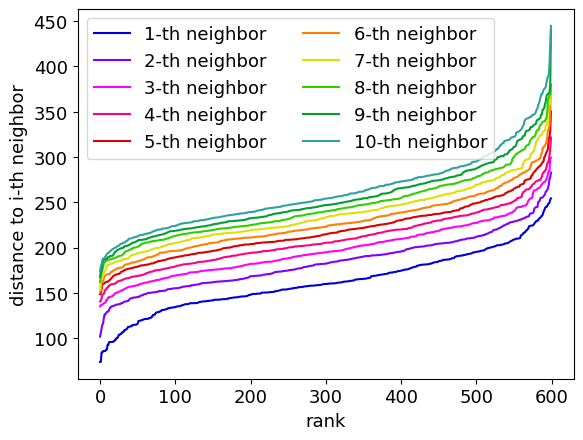

mean minimum distance to the first neighbor:  162.34622464324366
mean minimum distance to the second neighbor:  184.04201690089715
mean minimum distance to the third neighbor:  197.80319593476946


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x)  # assuming 'x' is your data
d, ind = nbrs.kneighbors(x)
dd = d.T

# Plot the distances to the first and second neighbors
listc = ["#0000DD", "#8000FF", "#FF00FF", "#FF0080", "#DD0000",
         "#FF8000", "#E0E000", "#30D000", "#00A030", "#33A0A0"]

for i in range(1, nn+1):
    plt.plot(np.sort(dd[i]), c=listc[i-1], label=f"{i}-th neighbor")
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")

plt.legend(ncol=2)
plt.show()

# Compute the mean distances to the first and second neighbors
mean_min_dist_1st = np.mean(dd[1])
mean_min_dist_2nd = np.mean(dd[2])
mean_min_dist_3rd = np.mean(dd[3])

print("mean minimum distance to the first neighbor: ", mean_min_dist_1st)
print("mean minimum distance to the second neighbor: ", mean_min_dist_2nd)
print("mean minimum distance to the third neighbor: ", mean_min_dist_3rd)

In [4]:
min_eps, max_eps, num_eps = 1, 300, 100
min_minPts, max_minPts, step_minPts = 1, 50, 1

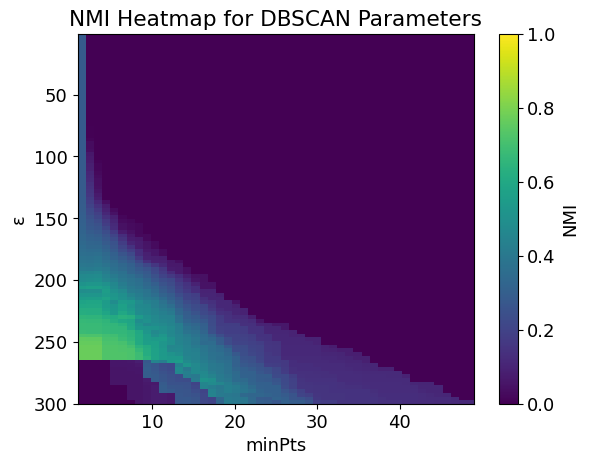

In [5]:
eps_values = np.linspace(min_eps, max_eps, num_eps)
minPts_values = np.arange(min_minPts, max_minPts, step_minPts)

# Initialize a 2D array to store NMI values
nmi_values = np.zeros((len(eps_values), len(minPts_values)))

# Loop through the grid and compute NMI for each combination
for i, eps in enumerate(eps_values):
    for j, minPts in enumerate(minPts_values):
        dbscan = DBSCAN(eps=eps, min_samples=minPts)
        predicted_labels = dbscan.fit_predict(data)
        nmi = normalized_mutual_info_score(y, predicted_labels)
        nmi_values[i, j] = nmi

# Plot the heatmap
plt.imshow(nmi_values, extent=[minPts_values[0], minPts_values[-1], eps_values[0], eps_values[-1]], aspect='auto', origin='lower')
plt.colorbar(label='NMI')
plt.clim(0, 1)  # Set color scale limits
plt.xlabel('minPts')
plt.ylabel('ε')
plt.title('NMI Heatmap for DBSCAN Parameters')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()

### Answer:

The first graph we look at shows us how the distance of neighbors varies based on rank. By observing the plotted distances, we can already get a sense of how the distances are distributed. We can choose either the average distance as the reference distance or look for a point in the plot where the distances exhibit a clear change in slope; choosing within this range can help capture meaningful local structures in our data.

However, the best combination of the values ​​of ε and minPts can be observed in the heatmap where the value of NMI (Normalized Mutual Information) tells us the agreement between the predicted clusters and the true clusters in my data; in particular, the higher is its value, the better the clustering will be, i.e. it will be closer to the real clustering structure of my data. As we can see, the heatmap shows us an almost linear relationship between ε and minPts, where as one increases the other also increases to have a high NMI value. Outside this region, the NMI value is zero, except for a small square which is approximately in a range of minPts between 1 and 7 and of ε between 230 and 260 which represents the region with the highest NMI: the value highest for NMI was found for approximately 257.29 and minPts 1, so these will be the parameters we will later use for our DBSCAN clustering.

### 2\. Understanding the 12-dimensional data
Use the principal component analysis (PCA) to visualize the first components of the data. Does it help understand its structure?

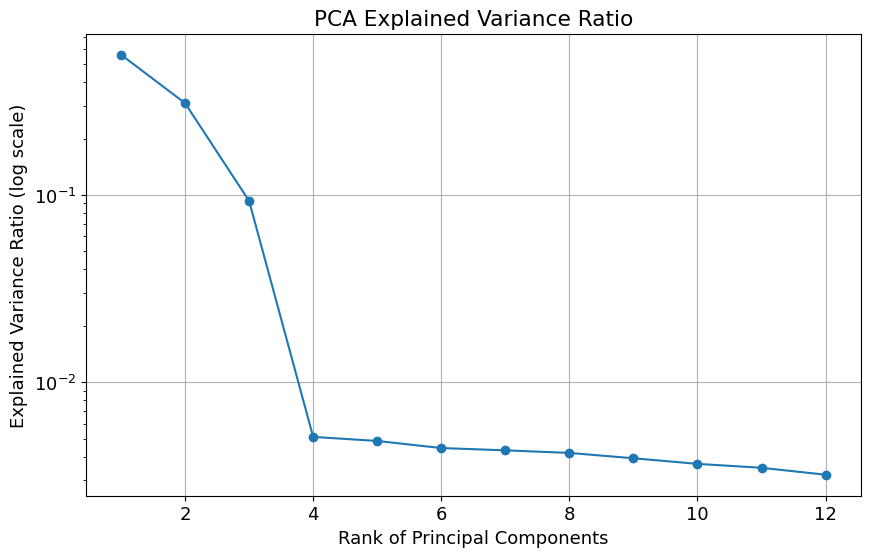

In [6]:
pca = PCA()
pca.fit(x)

# Plot the explained variance ratio over the number of the components
num_components = min(x.shape[0], x.shape[1])
components_range = np.arange(1, num_components + 1)

plt.figure(figsize=(10, 6))
plt.plot(components_range, pca.explained_variance_ratio_, marker='o')
plt.yscale('log')
plt.xlabel('Rank of Principal Components')
plt.ylabel('Explained Variance Ratio (log scale)')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

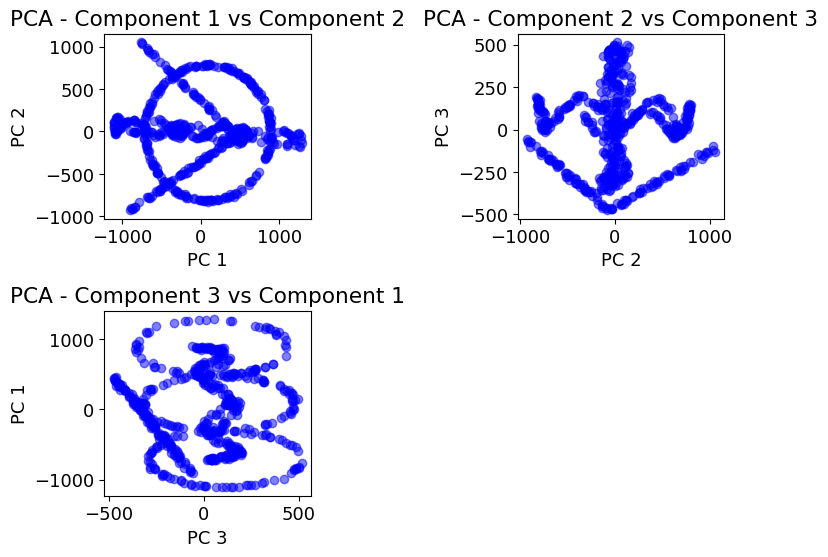

In [7]:
num_components = 3 # chosen from graph above
pca = PCA(n_components=num_components)
x_pca = pca.fit_transform(x)

# Plot the data in the PCA space
fig = plt.figure(figsize=(8, 6))
component_pairs = [(0, 1), (1, 2), (2, 0)]

for i, (comp1, comp2) in enumerate(component_pairs, start=1):
    ax = plt.subplot(2, 2, i)
    scatter = ax.scatter(x_pca[:, comp1], x_pca[:, comp2], c='b',alpha=0.5)
    ax.set_title(f'PCA - Component {comp1+1} vs Component {comp2+1}')
    ax.set_xlabel(f'PC {comp1+1}')
    ax.set_ylabel(f'PC {comp2+1}')

plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)

plt.show()

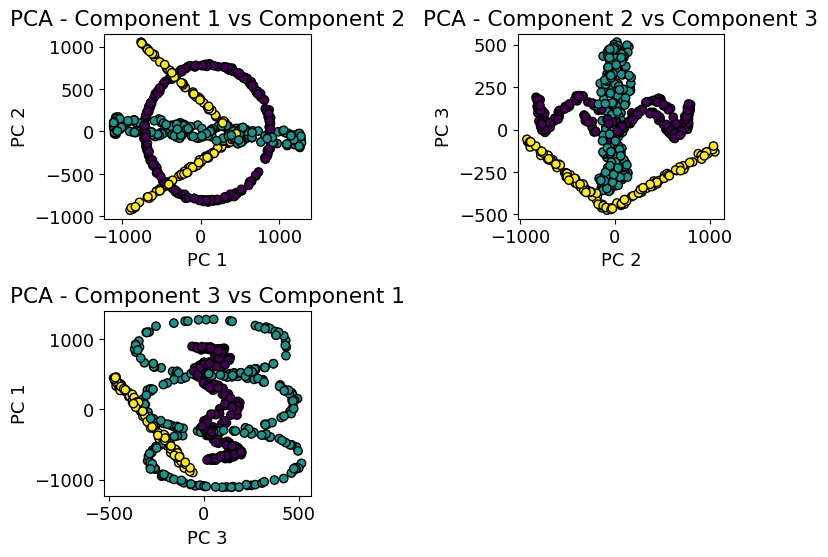

In [8]:
# TRUE LABEL CLUSTERING

fig = plt.figure(figsize=(8, 6))
component_pairs = [(0, 1), (1, 2), (2, 0)]

for i, (comp1, comp2) in enumerate(component_pairs, start=1):
    ax = plt.subplot(2, 2, i)
    scatter = ax.scatter(x_pca[:, comp1], x_pca[:, comp2], c=y, cmap='viridis', edgecolors='k')
    ax.set_title(f'PCA - Component {comp1+1} vs Component {comp2+1}')
    ax.set_xlabel(f'PC {comp1+1}')
    ax.set_ylabel(f'PC {comp2+1}')
plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)

plt.show()

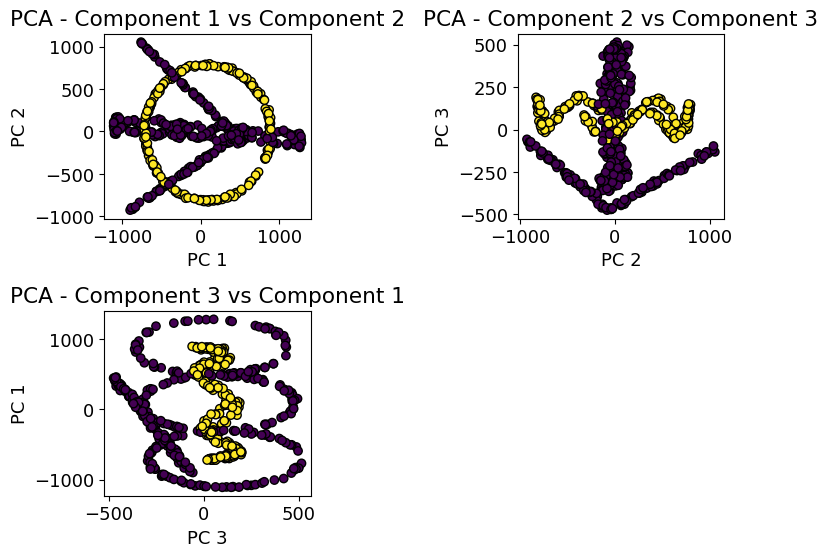

In [9]:
# DBSCAN CLUSTERING

eps_value = 257
min_samples_value = 1
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(x)

# Plot the data in the PCA space
fig = plt.figure(figsize=(8, 6))
component_pairs = [(0, 1), (1, 2), (2, 0)]

for i, (comp1, comp2) in enumerate(component_pairs, start=1):
    ax = plt.subplot(2, 2, i)
    scatter = ax.scatter(x_pca[:, comp1], x_pca[:, comp2], c=dbscan_labels, cmap='viridis', edgecolors='k')
    ax.set_title(f'PCA - Component {comp1+1} vs Component {comp2+1}')
    ax.set_xlabel(f'PC {comp1+1}')
    ax.set_ylabel(f'PC {comp2+1}')

plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)

plt.show()

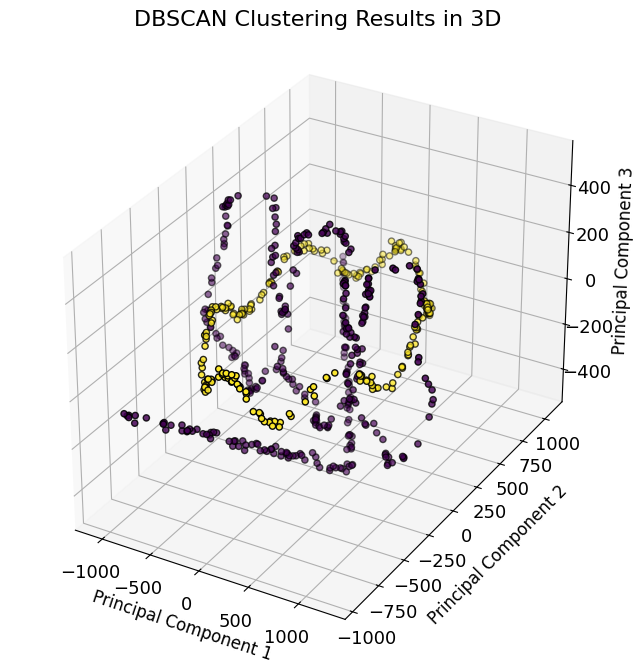

In [10]:
# 3D VISUALIZATION OF THE DBSCAN CLUSTERING

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=dbscan_labels, cmap='viridis', edgecolors='k')

ax.set_title('DBSCAN Clustering Results in 3D', fontsize=16)
ax.set_xlabel('Principal Component 1', fontsize=12,labelpad=3)
ax.set_ylabel('Principal Component 2', fontsize=12,labelpad=13)
ax.set_zlabel('Principal Component 3', fontsize=12, labelpad=7)
ax.set_box_aspect([2,3,2])
plt.show()

### Answer

First of all, from the first graph, where we plot the explained variance ratio over the components, we can clearly see that only the first three components are relevant, while the other are negligible. Thus, we can perform the PCA analysis with 3 principal components: this helps understand the dataset because it removes the negligible components, so we obtained a dataset with a smaller dimensionality where the clusters are more evident and relevant.

In the other graphs we can see:
- the true labels and the clustering we expect from a 100% accurate algorithm.
- the DBSCAN clustering, obtained fitting the data obtained from the PCA with a DBSCAN algorithm with the best parameters that we found in Question 1.
- a 3D visualization of the DBSCAN clustering.

### 3\. Compare different clustering methods
a) Perform a k-means clustering of the data, with k=3. Does it work better than DBSCAN? Why?

b) Perform a hierarchical clustering of the data and plot the corresponding dendrogram. 
Does it work better than DBSCAN?

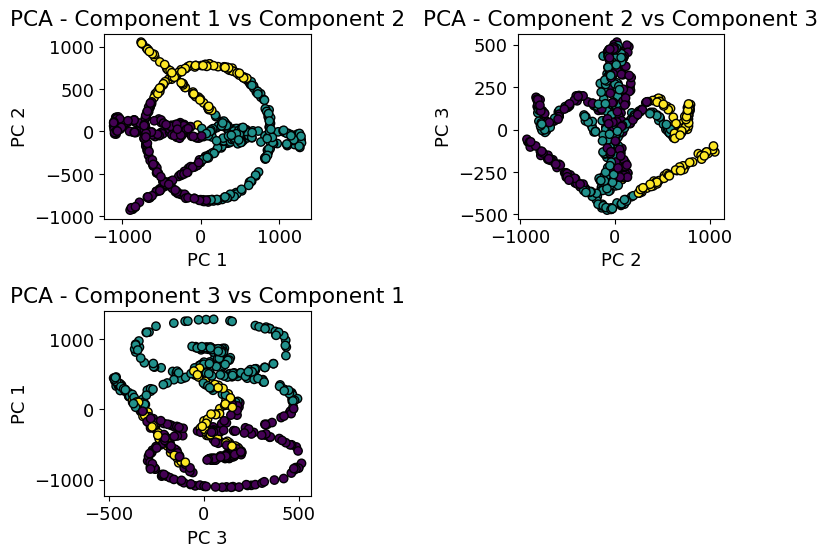

In [11]:
# K-MEANS CLUSTERING
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(x)

# Plot the data in the PCA space
fig = plt.figure(figsize=(8, 6))
component_pairs = [(0, 1), (1, 2), (2, 0)]

for i, (comp1, comp2) in enumerate(component_pairs, start=1):
    ax = plt.subplot(2, 2, i)
    scatter = ax.scatter(x_pca[:, comp1], x_pca[:, comp2], c=kmeans_labels, cmap='viridis', edgecolors='k')
    ax.set_title(f'PCA - Component {comp1+1} vs Component {comp2+1}')
    ax.set_xlabel(f'PC {comp1+1}')
    ax.set_ylabel(f'PC {comp2+1}')

plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)

plt.show()

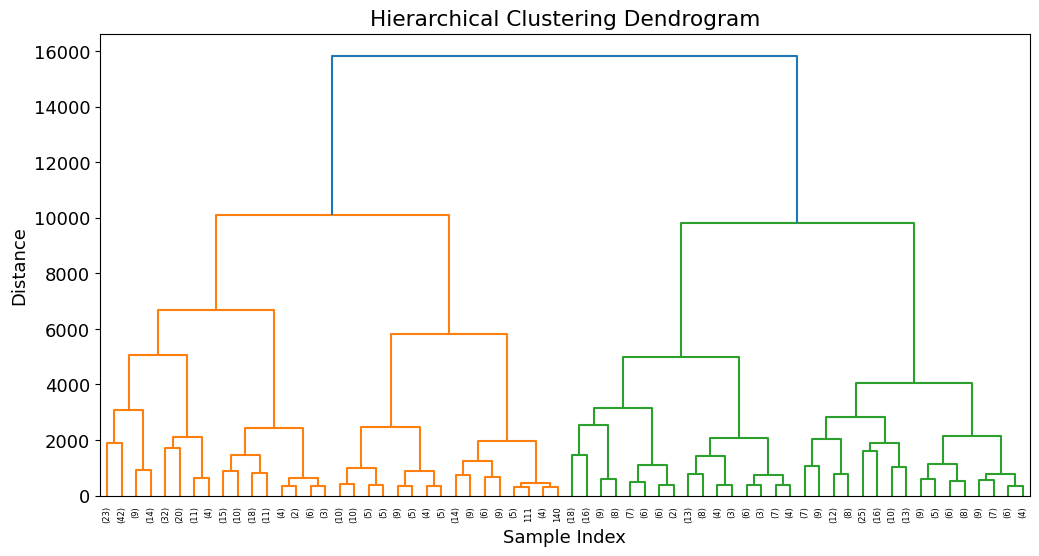

In [12]:
# HIERARCHICAL CLUSTERING DENDOGRAM

linkage_matrix = linkage(x, method='ward', metric='euclidean')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, p=5, truncate_mode='level', orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

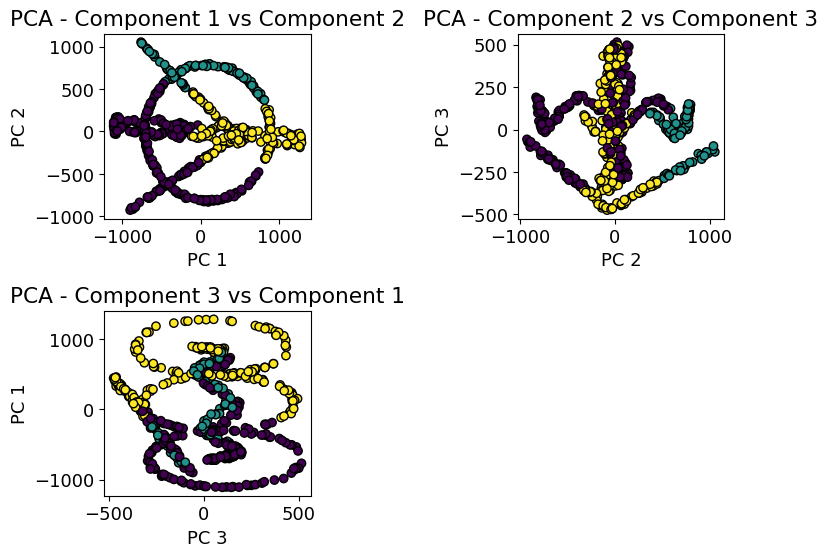

In [13]:
# HIERARCHICAL CLUSTERING

num_clusters = 3 
hierarchical_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

fig = plt.figure(figsize=(8, 6))
component_pairs = [(0, 1), (1, 2), (2, 0)]

for i, (comp1, comp2) in enumerate(component_pairs, start=1):
    ax = plt.subplot(2, 2, i)
    scatter = ax.scatter(x_pca[:, comp1], x_pca[:, comp2], c=hierarchical_labels, cmap='viridis', edgecolors='k')
    ax.set_title(f'PCA - Component {comp1+1} vs Component {comp2+1}')
    ax.set_xlabel(f'PC {comp1+1}')
    ax.set_ylabel(f'PC {comp2+1}')

plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.5)

plt.show()

In [14]:
# CLUSTERING EFFICIENCY

clustering_algorithms = ['PCA', 'DBSCAN', 'K-Means', 'Hierarchical']
clustering_labels = [y, dbscan_labels, kmeans_labels, hierarchical_labels]

for algorithm, labels in zip(clustering_algorithms, clustering_labels):
    nmi_score = normalized_mutual_info_score(y, labels)
    print(f"NMI Score for {algorithm} clustering:", nmi_score)

NMI Score for PCA clustering: 1.0
NMI Score for DBSCAN clustering: 0.7714454028652104
NMI Score for K-Means clustering: 0.09756505464495659
NMI Score for Hierarchical clustering: 0.14402130604588254


### Answer:

We found that DBSCAN was the best method for clustering (considrering the best values ​​of ε and minPts) compared to K-Means and the hierarchical clustering method. This decision was made by:
- observing the NMI value, which is equal to 0.10 for K-Means and 0.14 for the hierarchical, very low compared to the NMI value of the DBSCAN clustering, which suggests little agreement with the data.
- a visual observation of the graphs, studying how the various clusters are divided. DBSCAN is the only one that, despite dividing the data into only two clusters, maintains the division similar to the real one, while K-Means and hierarchical clusterind divide in a completely different way.

Thus we concluded that DBSCAN clustering is the best one for this dataset.

### 4\. OPTIONAL: Visualize the data with other methods from the scikit package

standard: 0.16 sec
ltsa: 0.15 sec
hessian: 0.22 sec
modified: 0.15 sec
ISO: 0.26 sec


/home/kallo27/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS: 1 sec
Spectral Embedding: 0.11 sec
t-SNE: 1.7 sec


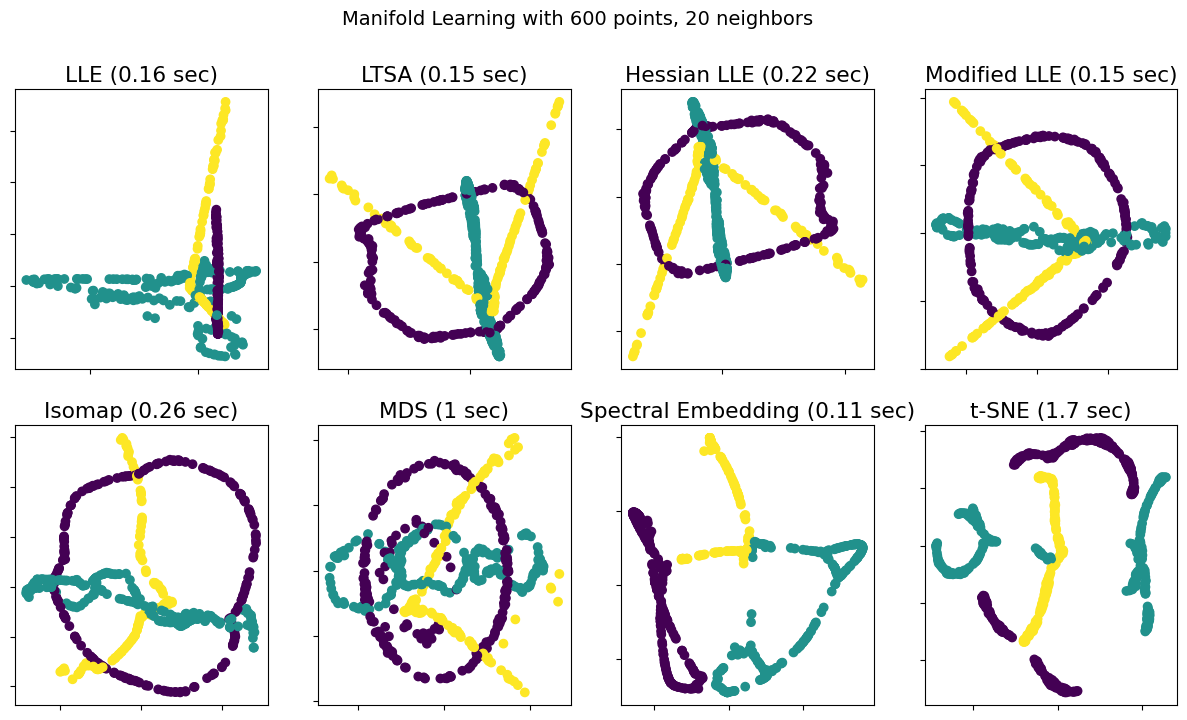

In [19]:
# Variables for manifold learning.
n_neighbors = 20
n_samples = 600

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors" % (n_samples, n_neighbors), fontsize=14)

# Perform Locally Linear Embedding Manifold learning
methods = ["standard", "ltsa", "hessian", "modified"]
labels = ["LLE", "LTSA", "Hessian LLE", "Modified LLE"]

for i, method in enumerate(methods):
    t0 = time()
    trans_data = (
        manifold.LocallyLinearEmbedding(
            n_neighbors=n_neighbors, n_components=2, method=method, random_state=42
        )
        .fit_transform(x_pca)
        .T
    )
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(241 + i)
    ax.scatter(trans_data[0], trans_data[1], c=y, cmap='viridis')
    ax.set_title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

# Perform Isomap Manifold learning.
t0 = time()
trans_data = (manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(x_pca).T)
t1 = time()
print("%s: %.2g sec" % ("ISO", t1 - t0))

ax = fig.add_subplot(245)
ax.scatter(trans_data[0], trans_data[1], c=y, cmap='viridis')
ax.set_title("%s (%.2g sec)" % ("Isomap", t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")

# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1, random_state=42)
trans_data = mds.fit_transform(x_pca).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(246)
ax.scatter(trans_data[0], trans_data[1], c=y, cmap='viridis')
ax.set_title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=n_neighbors, random_state=42)
trans_data = se.fit_transform(x_pca).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(247)
ax.scatter(trans_data[0], trans_data[1], c=y, cmap='viridis')
ax.set_title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(x_pca).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(248)
ax.scatter(trans_data[0], trans_data[1], c=y, cmap='viridis')
ax.set_title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")

plt.show()